## Project Report: Analysis of peoples interest in livestreams of published video games

**Name:** Kevin Kocev \
**Submit date:** 10th January 2024

### Introduction

Are popular published video games also popular livestream formats? The main question may sound trivial at first, but upon further consideration, it genuinely raises the question of what answer it holds. Particularly in view of the advertising impact of presenting video games on streaming platforms such as Twitch or YouTube, it could be interesting for game developers to ask themselves in advance whether a new game will also have a corresponding reach of streamers and viewers. The information could also be interesting for deciding whether to actively invest in streaming as an advertising channel in order to increase the reach of the game on the relevant platforms.

The aim of this data science project is to provide insights into the popularity of video games among players and viewers, and, if possible, to identify correlations by answering the research question. For this purpose, alongside the methodology, plots are presented for visualization to give an impression of the data. The results are interpreted in the conclusion/discussion with relation to the research question.

### Methods

#### Data sources

The following data sources are used for this project:

* **Datasource 1: Top games on Twitch 2016 - 2023**
  * Metadata URL: https://www.kaggle.com/datasets/rankirsh/evolution-of-top-games-on-twitch
  * Data URL: https://www.kaggle.com/datasets/rankirsh/evolution-of-top-games-on-twitch/download?datasetVersionNumber=16
  * Data Type: CSV

This data source contains information from Twitch, a streaming platform where users can stream their own content of various types. More specifically, data for the most popular 200 categories has been collected monthly from 2016 to 2023 (at the time of the project report), including metrics such as hours watched/streamed, average viewers, and streamers.

In this project report, the data source is utilized to analyze the popularity of video games on the Twitch platform, primarily focusing on hours watched as this attribute most effectively reflects a game's popularity.

* **Datasource 2: Popular Video Games**
  * Metadata URL: https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games
  * Data URL: https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games/download?datasetVersionNumber=1
  * Data Type: CSV

This data source, on the other hand, has collected metadata and information about popular video games using the Backloggd service. The idea was based on another data source that had a smaller number of games, leading to the creation of this more extensive data source. Alongside the game title, additional data such as genres, released platforms, and the development team have been recorded. As different genres play a more significant role in the process of this project report, they are briefly explained in advance. A video game genre is a category that classifies games based on common characteristics and gameplay mechanics. These genres help players identify suitable games based on their preferences. Each genre represents a different theme, although games can also cover multiple genres simultaneously. In the specific data source, genres such as RPG (Role-Playing Game) are present, indicating that the player takes on the role of a specific character in the game. Another example is MOBA (Multiplayer Online Battle Arena), signifying that the game allows players to compete against others, usually in teams. In general, there are many genres, which is why it is refrained from explaining each one in detail. However, these examples should help provide an impression of what video game genres involve.

The use in this project report involves expanding the data from Twitch (Data Source 1) to have an easier way to generalize games and conduct better analyses. Genres of a game are extensively utilized as they provide a good means to categorize and compare games. Furthermore, plays are used to gain an overview of the game's popularity among users.

#### Data pipeline

As the data pipeline uses data from Kaggle and access is secured via API credentials, the access data for the API must be read in before the data pipeline can be executed. A bash script is used as an entry point for this, which performs the configuration.

The data pipeline can then be executed, whereby the following steps are performed individually for each data source:

1. First, the data is downloaded and unpacked directly, whereby if there are several datasets, only those that will be used for the subsequent analysis are kept. The data is then read in and, if necessary, corrections are made to the files beforehand to prevent problems during import.
2. After the data has been read in, it is prepared by selecting, transforming or converting it.
3. The prepared data is then stored in an SQLite database in a separate table.
4. Finally, the raw data files are deleted so that only the SQLite database remains.

After each individual data source has been processed, an additional table is created in the SQLite database, which contains the combination of the two data sources in order to be able to perform comprehensive analyses. In this specific case, metadata for the associated games is added to the Twitch data, if available.

#### Data cleaning/transformation

As mentioned in the section on the data pipeline, data is prepared before being stored. The following steps provide a closer look at these processes for each data source.

**Data Source 1: Top games on Twitch 2016 - 2023**

Columns that are not used for data analysis, such as `Rank`, `Streamers`, and `Avg_viewer_ratio`, are removed. Additionally, since Twitch allows streaming content unrelated to games, all categories that do not correspond to a game are removed.

**Data Source 2: Popular Video Games**

Similar to the first source, columns not utilized for later data analysis, such as `Summary`, `Rating`, or `Reviews`, are removed. Furthermore, the total plays of individual games are converted into numerical values, as thousands were abbreviated with "K". Platforms and Genres are also converted into comma-separated strings to simplify conversion into lists which ease the data analysis.

#### Problems

In the execution of Data Engineering, there were no fundamental issues. However, there were encoding problems with Data Source 1, causing certain UTF-8 characters to be incorrectly displayed, complicating the merging process with metadata from Data Source 2. After manual inspection, the focus was on the character é, which had to be replaced manually when using the Code Point representation.

Another issue is the absence of data. Despite the good quality of the two data sources, there are missing data that would have been helpful for a more in-depth analysis. For instance, sales data or active players on a monthly basis, as in Data Source 1, would have helped in illustrating monthly or yearly trends between games and streams. Even alternative data sources lacked such a data structure, leaving Web Scraping or APIs as the only alternative, which would have exceeded the project scope and not met the specified project conditions.

### Results

The data is presented graphically below to give an impression of the information and results.

#### Preparation

Steps that are necessary to work with the data.

##### Install dependencies

In [46]:
%pip install kaggle
%pip install pandas
%pip install sqlalchemy
%pip install matplotlib
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


##### Import modules

In [47]:
import os
import subprocess
import sys
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

##### Run data pipeline (if needed)

In [48]:
# Important: Set valid kaggle API credentials to use the data pipeline

# - - - KAGGLE SETUP START - - -
KAGGLE_USERNAME = ''
KAGGLE_KEY = ''
# - - - KAGGLE SETUP END - - -

In [49]:
# Run data pipeline if database doesn't exist
if not os.path.exists('../data/data.sqlite'):
    # Copy custom environment
    custom_env = os.environ.copy()

    # Check if kaggle credentials are set
    if (len(KAGGLE_USERNAME) <= 0 or len(KAGGLE_KEY) <= 0):
        print("You need to run the data pipeline but didn't set the kaggle API credentials", file=sys.stderr)

    # Make sure the data pipeline aren't executed if the credentials are not set
    assert(len(KAGGLE_USERNAME) > 0 and len(KAGGLE_KEY) > 0)

    # Update environment
    custom_env['KAGGLE_USERNAME'] = KAGGLE_USERNAME
    custom_env['KAGGLE_KEY'] = KAGGLE_KEY

    # Run subprocess with custom environment
    subprocess.run(['python3', 'project/pipeline.py'], env=custom_env, cwd='..')

- - - - - Starting data pipeline - - - - -
- - - - - Start pipeline for datasource 1: Top games on Twitch 2016 - 2023 - - - - -
Datasource 1: Download and load
Datasource 1: Prepare
Datasource 1: Store
Datasource 1: Delete raw csv(s)
- - - - - Start pipeline for datasource 2: Popular Video Games - - - - -
Datasource 2: Download and load
Datasource 2: Prepare
Datasource 2: Store
Datasource 2: Delete raw csv(s)
- - - - - Final: Combine datasources - - - - -
Combine datasources
- - - - - Finished data pipeline - - - - -


##### Load data

In [50]:
# Load data from SQLite database
con = sa.create_engine('sqlite:///../data/data.sqlite?charset=utf8')
df_tg = pd.read_sql_table('twitch_games', con)
df_pvg = pd.read_sql_table('popular_video_games', con)
df_merged = pd.read_sql_table('merged', con)

#### Data presentation

##### Video games by genre

The bar chart displays the number of all video games in a genre in descending order. The x-axis represents the cumulative quantity of all video games within a genre, while the y-axis encompasses all available genres.

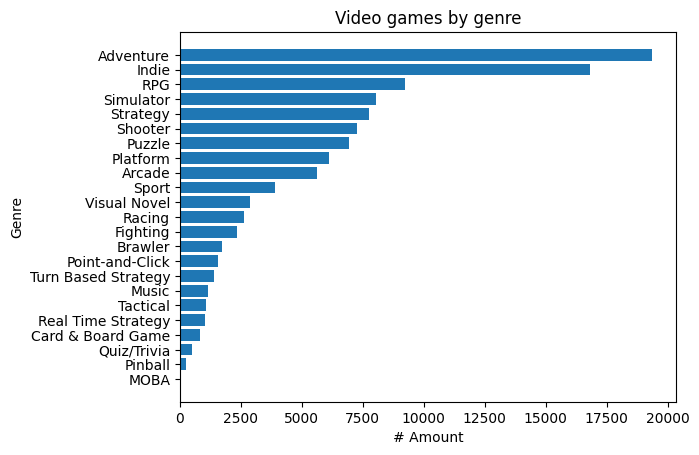

In [51]:
# Get genres of games
df_plot1 = df_pvg['Genres']
# Drop rows with NaN
df_plot1 = df_plot1.dropna()
# Convert values to list for usage with explode
df_plot1 = df_plot1.apply(lambda x: x.split(', '))
# Split values in single rows
df_plot1 = df_plot1.explode()

# Get values for all genres
genres_grouped = df_plot1.value_counts()

# Build plot
plt.title("Video games by genre")
plt.xlabel('# Amount')
plt.ylabel('Genre')
plt.barh(genres_grouped.index[::-1], genres_grouped[::-1])

# Show plot
plt.show()

##### Top 10 of most popular video games by plays

The ranking showcases the top 10 video games with the highest plays in descending order. The x-axis represents the plays (in thousands) for each video game, while the y-axis includes the names of the individual video games.

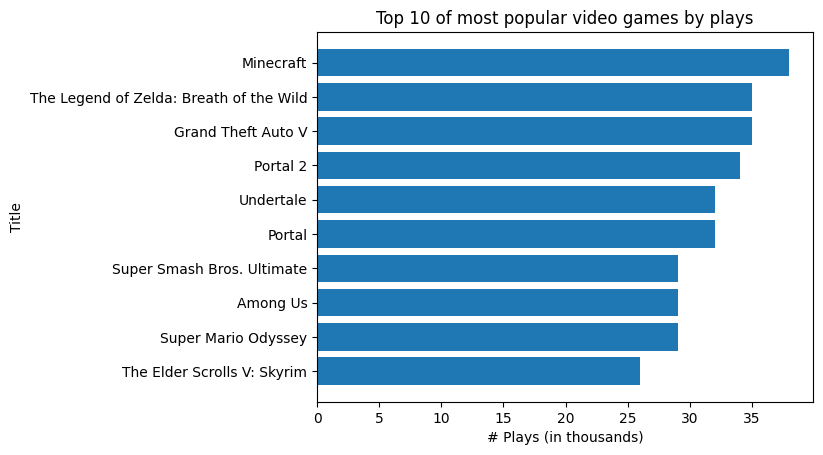

In [52]:
# Get top 10 of video games by plays
df_plot2 = df_pvg.sort_values(['Plays'], ascending=False).head(10)

# Convert plays in smaller values for better plot
df_plot2['Plays'] = df_plot2['Plays'] / 1000

# Build plot
plt.title("Top 10 of most popular video games by plays")
plt.xlabel('# Plays (in thousands)')
plt.ylabel('Title')
plt.barh(df_plot2['Title'][::-1], df_plot2['Plays'][::-1])

# Show plot
plt.show()

##### Video game genres by average plays

The bar chart displays video games grouped by genres. The x-axis represents the average plays (in hundreds) per genre, while the y-axis includes the names of the genres. The genres are sorted in descending order based on the average plays.

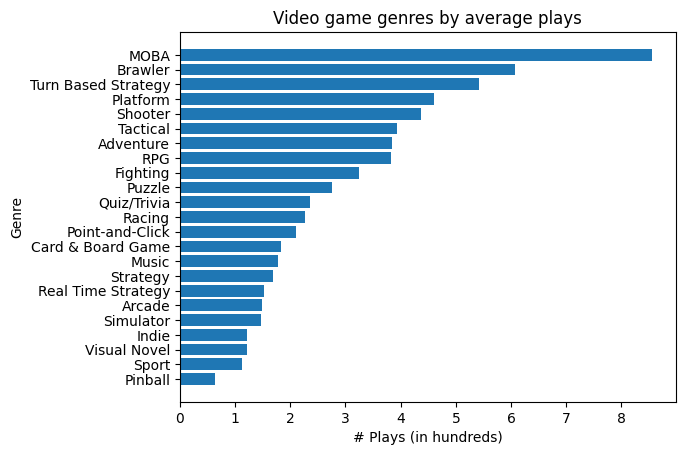

In [53]:
# Get columns
df_plot3 = df_pvg[['Genres', 'Plays']]
# Drop rows with NaN
df_plot3 = df_plot3.dropna()
# Convert values to list for usage with explode
df_plot3['Genres'] = df_plot3['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot3 = df_plot3.explode('Genres')

# Group genres, sum plays and sort them
genres_grouped = df_plot3.groupby('Genres').mean()
genres_grouped = genres_grouped.sort_values('Plays', ascending=False)

# Convert plays in smaller values for better plot
genres_grouped['Plays'] = genres_grouped['Plays'] / 100

# Build plot
plt.title("Video game genres by average plays")
plt.xlabel('# Plays (in hundreds)')
plt.ylabel('Genre')
plt.barh(genres_grouped.index[::-1], genres_grouped['Plays'][::-1])

# Show plot
plt.show()

##### Top 10 most popular games by hours watched

The following ranking showcases the top 10 most successful video games on Twitch based on hours watched. The x-axis represents the sum of hours watched (in billions), while the y-axis represents the names of the games, sorted in descending order based on the highest hours watched.

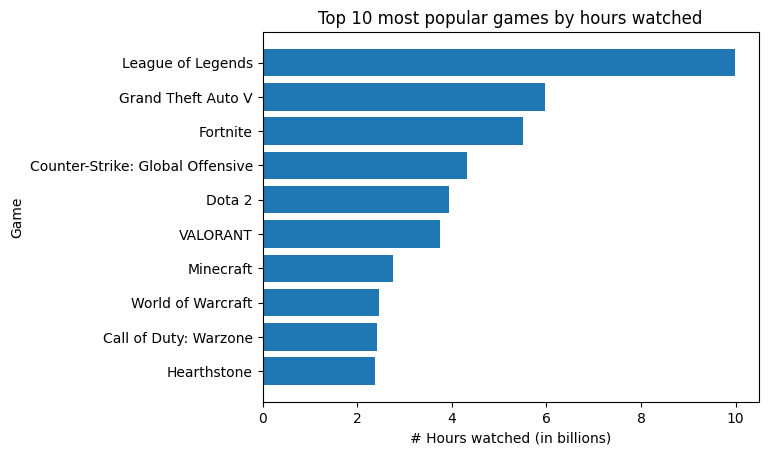

In [54]:
# Get games and watched hours
df_plot4 = df_tg[['Game', 'Hours_watched']]

# Group games, calculate sum of watched hours and sort appearances
df_plot4 = df_plot4.groupby('Game').sum()
df_plot4 = df_plot4.sort_values('Hours_watched', ascending=False).head(10)

# Convert watched hours in smaller values for better plot
df_plot4['Hours_watched'] = df_plot4['Hours_watched'] / 1000000000

# Build plot
plt.title("Top 10 most popular games by hours watched")
plt.xlabel('# Hours watched (in billions)')
plt.ylabel('Game')
plt.barh(df_plot4.index[::-1], df_plot4['Hours_watched'].values[::-1])

# Show plot
plt.show()

##### Twitch streamed and watched hours per year

The illustration shows hours watched and hours streamed on Twitch over the various years. The left bar chart displays the total hours watched per year, while the right bar chart illustrates the hours streamed per year. The x-axis of both bar charts indicates the different years, ranging from 2016 to 2023 (as of the project report). The y-axis in the left chart represents the sum of hours watched (in billions), while the y-axis on the right chart represents hours streamed (in millions).

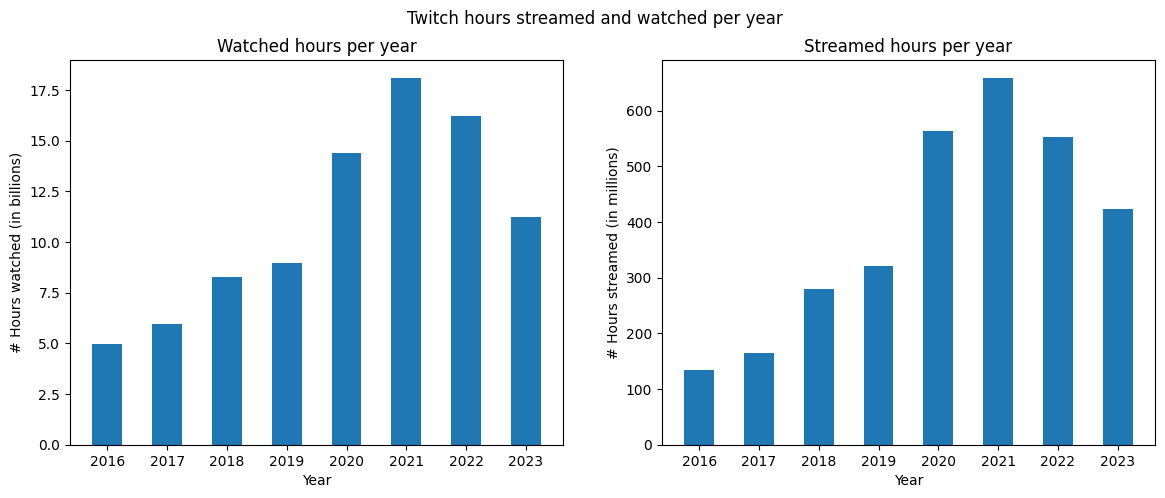

In [55]:
# Get years and watched/streamed hours
df_plot5 = df_tg[['Year', 'Hours_watched', 'Hours_streamed']]

# Group by year and get mean of watched/streamed hours
df_plot5 = df_plot5.groupby('Year').agg({
    'Hours_watched': 'sum',
    'Hours_streamed': 'sum'
})

# Convert watched hours in smaller values for better plot
df_plot5['Hours_watched'] = df_plot5['Hours_watched'] / 1000000000
df_plot5['Hours_streamed'] = df_plot5['Hours_streamed'] / 1000000

# Build plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Twitch hours streamed and watched per year")

# Plot 1 for watched hours per year
ax1.set_title("Watched hours per year")
ax1.bar(df_plot5.index[::-1], df_plot5['Hours_watched'].values[::-1], width=0.5)
ax1.set_xlabel('Year')
ax1.set_ylabel('# Hours watched (in billions)')

# Plot 2 for streamed hours per year
ax2.set_title("Streamed hours per year")
ax2.bar(df_plot5.index[::-1], df_plot5['Hours_streamed'].values[::-1], width=0.5)
ax2.set_xlabel('Year')
ax2.set_ylabel('# Hours streamed (in millions)')

# Show plot
plt.show()

##### Video game genres by average hours watched

In the following bar chart, all streamed games are grouped into their respective genres, and the average hours watched for each genre are depicted. The x-axis represents the average hours watched (in millions), while the y-axis displays the individual genres. The genres are sorted in descending order based on their highest average hours watched.

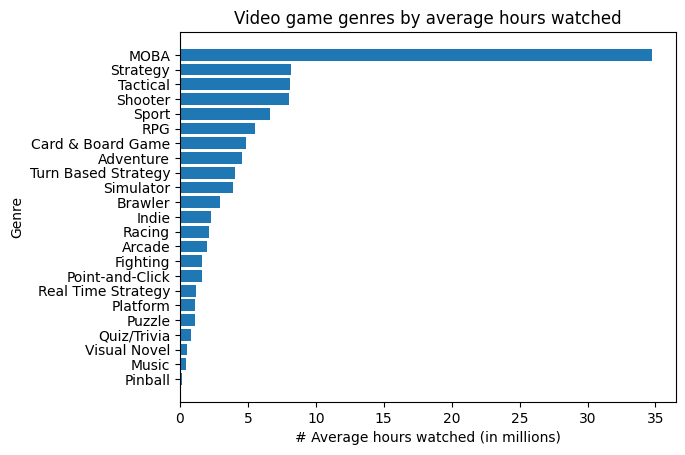

In [56]:
# Get years and watched/streamed hours
df_plot6 = df_merged[['Hours_watched', 'Genres']]
# Drop rows with NaN
df_plot6 = df_plot6.dropna()
# Convert values to list for usage with explode
df_plot6['Genres'] = df_plot6['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot6 = df_plot6.explode('Genres')

# Group genres, calculate average watched hours and sort appearances
df_plot6 = df_plot6.groupby('Genres').mean()
df_plot6 = df_plot6.sort_values('Hours_watched', ascending=False)

# Convert watched hours in smaller values for better plot
df_plot6['Hours_watched'] = df_plot6['Hours_watched'] / 1000000

# Build plot
plt.title("Video game genres by average hours watched")
plt.xlabel('# Average hours watched (in millions)')
plt.ylabel('Genre')
plt.barh(df_plot6.index[::-1], df_plot6['Hours_watched'].values[::-1])

# Show plot
plt.show()

##### Average watched hours on Twitch per year by genre

The following heatmap displays the average hours watched on Twitch for each genre in each year with color highlighting based on the values. The x-axis represents the individual years from 2016 to 2023 (as of this project report). On the y-axis, all games are grouped into their respective genres and showed. The values in the individual cells represent the average hours watched (in millions) for each genre in each year, with high values in red and low values in blue, as indicated in the color bar.

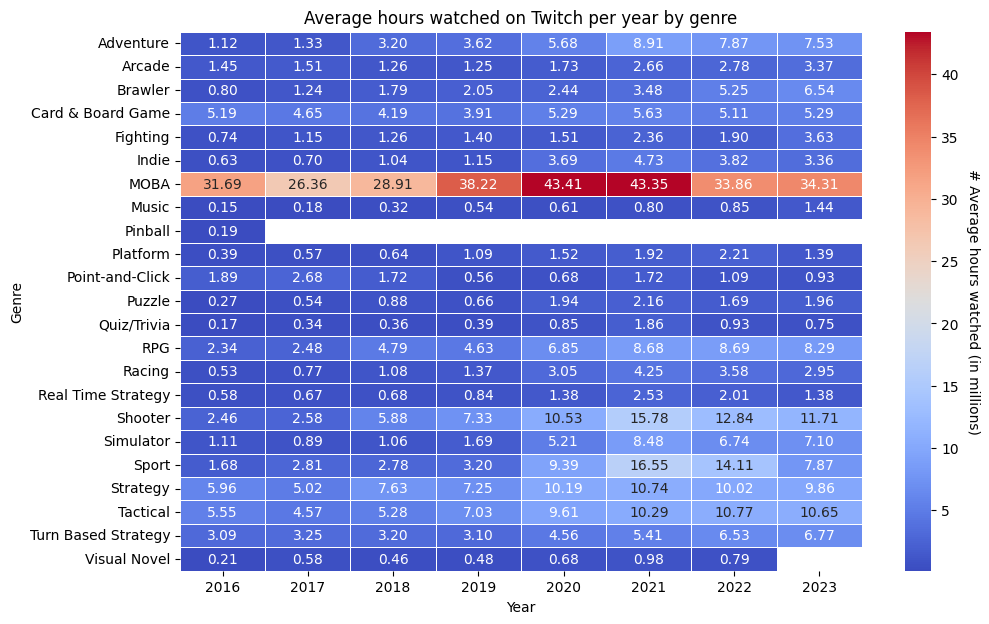

In [57]:
# Get years, genres, watched hours
df_plot7 = df_merged[['Year', 'Hours_watched', 'Genres']]
# Drop rows with NaN
df_plot7 = df_plot7.dropna()
# Convert values to list for usage with explode
df_plot7['Genres'] = df_plot7['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot7 = df_plot7.explode('Genres')
# Rename Genres to Genre (for plot)
df_plot7 = df_plot7.rename({'Genres': 'Genre'}, axis='columns')

# Group genres, calculate average watched hours and sort appearances
df_plot7 = df_plot7.groupby(['Genre', 'Year']).mean()

# Convert watched hours in smaller values for better plot
df_plot7['Hours_watched'] = df_plot7['Hours_watched'] / 1000000

# Unstack MultiIndex to get DataFrame with genres and years as rows
df_plot7 = df_plot7['Hours_watched'].unstack()

# Build plot
plt.figure(figsize=(11, 7))
plt.title("Average hours watched on Twitch per year by genre")

# Create Heatmap
heatmap = sns.heatmap(df_plot7, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("# Average hours watched (in millions)", rotation=270, labelpad=15)

# Show plot
plt.show()

##### Development of average hours watched on Twitch per year from 2016 per genre

The following heatmap illustrates the percentage change in average hours watched on Twitch for each genre in each year compared to the previous year, with color highlighting based on the values. The x-axis represents the individual years from 2017 to 2023 (as of this project report). The first year (in this case, 2016) is discarded as it is the starting year, and no development is known. From the year 2017 onward, the development is then displayed, with 2017 in relation to 2016. On the y-axis, all games are grouped into their respective genres and depicted. The values in the individual cells represent the percentage change in average hours watched per genre compared to the previous year. Growth is represented in shades of red, while a negative trend is shown in shades of blue, as indicated in the color bar.

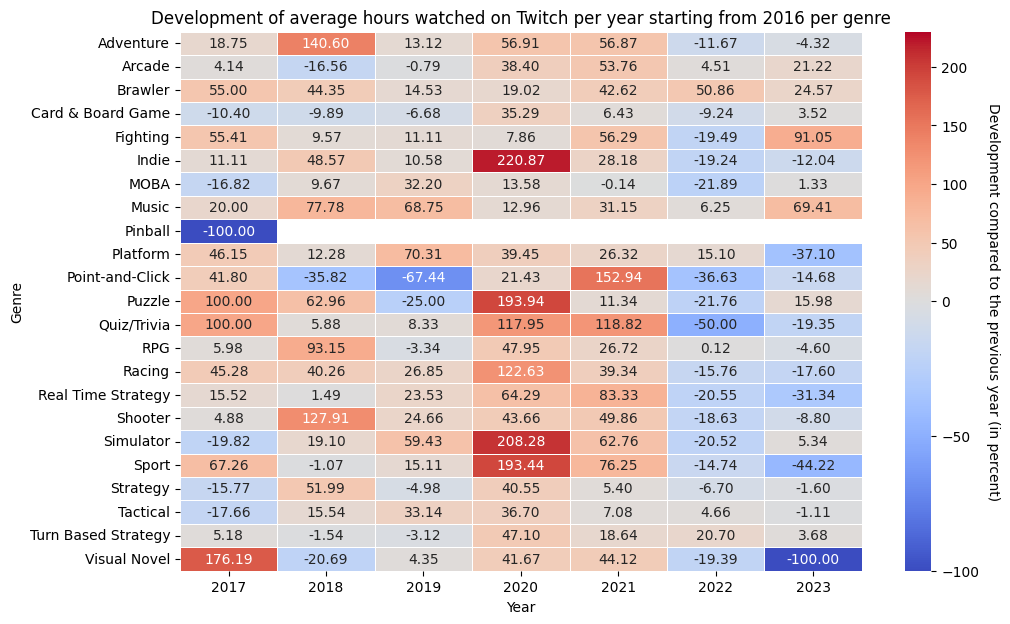

In [58]:
# Get years, genres, watched hours
df_plot8 = df_merged[['Year', 'Hours_watched', 'Genres']]
# Drop rows with NaN
df_plot8 = df_plot8.dropna()
# Convert values to list for usage with explode
df_plot8['Genres'] = df_plot8['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot8 = df_plot8.explode('Genres')
# Rename Genres to Genre (for plot)
df_plot8 = df_plot8.rename({'Genres': 'Genre'}, axis='columns')

# Group genres, calculate average watched hours and sort appearances
df_plot8 = df_plot8.groupby(['Genre', 'Year']).mean()

# Convert hours watched to use the same conditions as the previous plot
df_plot8['Hours_watched'] = df_plot8['Hours_watched'] / 1000000
df_plot8['Hours_watched'] = df_plot8['Hours_watched'].round(2)

# Unstack MultiIndex to get DataFrame with genres and years as rows
df_plot8 = df_plot8['Hours_watched'].unstack()

# Fill NaN with zero
df_plot8 = df_plot8.fillna(0)

# Calculate percentage change from previous to next year
df_plot8 = df_plot8.pct_change(axis=1, fill_method=None) * 100

# Drop column 2016 because it has no values (starter column for year development)
df_plot8 = df_plot8.drop(2016, axis=1)

# Build plot
plt.figure(figsize=(11, 7))
plt.title("Development of average hours watched on Twitch per year starting from 2016 per genre")

# Create Heatmap
divnorm=colors.TwoSlopeNorm(vmin=-100., vcenter=0., vmax=230)
heatmap = sns.heatmap(df_plot8, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, norm=divnorm)
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("Development compared to the previous year (in percent)", rotation=270, labelpad=15)

# Show plot
plt.show()

##### Share of each genre in the total average hours watched on Twitch per year

The following heatmap illustrates the percentage share of each genre in the total average hours watched on Twitch in each year. The x-axis represents the individual years from 2016 to 2023 (as of this project report). On the y-axis, all games are grouped into their respective genres and depicted. The values in the individual cells represent the percentage share of the genre in the total average hours watched. High shares are depicted in shades of red, while low shares are shown in shades of blue, as indicated in the color bar.

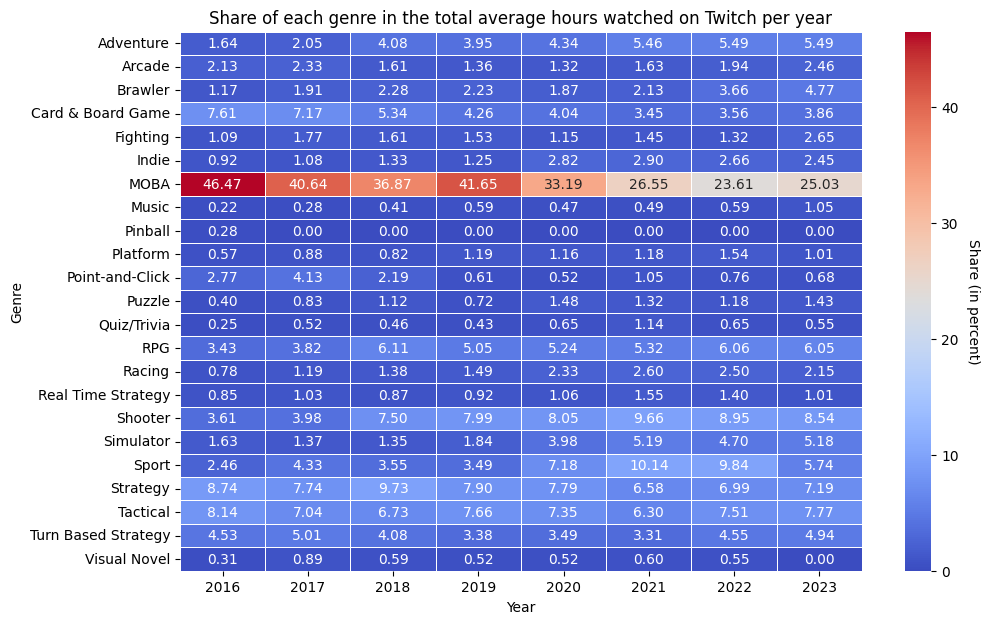

In [59]:
# Get years, genres, watched hours
df_plot9 = df_merged[['Year', 'Hours_watched', 'Genres']]
# Drop rows with NaN
df_plot9 = df_plot9.dropna()

# Convert values to list for usage with explode
df_plot9['Genres'] = df_plot9['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot9 = df_plot9.explode('Genres')
# Rename Genres to Genre (for plot)
df_plot9 = df_plot9.rename({'Genres': 'Genre'}, axis='columns')

# Group genres, calculate average watched hours and sort appearances
df_plot9 = df_plot9.groupby(['Genre', 'Year']).mean()

# Convert hours watched to use the same conditions as the previous plot
df_plot9['Hours_watched'] = df_plot9['Hours_watched'] / 1000000
df_plot9['Hours_watched'] = df_plot9['Hours_watched'].round(2)

# Unstack MultiIndex to get DataFrame with genres and years as rows
df_plot9 = df_plot9['Hours_watched'].unstack()

# Fill NaN with zero
df_plot9 = df_plot9.fillna(0)

# Calculate percentage of total average watched hours for each genre in each year
df_plot9 = df_plot9.divide(df_plot9.sum(axis=0), axis=1) * 100

# Build plot
plt.figure(figsize=(11, 7))
plt.title("Share of each genre in the total average hours watched on Twitch per year")

# Create Heatmap
heatmap = sns.heatmap(df_plot9, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("Share (in percent)", rotation=270, labelpad=15)

# Show plot
plt.show()

##### Development of share of the individual genres from 2016 to 2023 on Twitch

The following diverging plot illustrates the percentage change in the share of the total average hours watched on Twitch from 2016 to 2023 (as of this project report). The x-axis depicts the change in the share (in percent), with green values indicating a positive trend and red values indicating a negative trend. On the y-axis, the individual genres of the games are represented, sorted in descending order based on their respective developments.

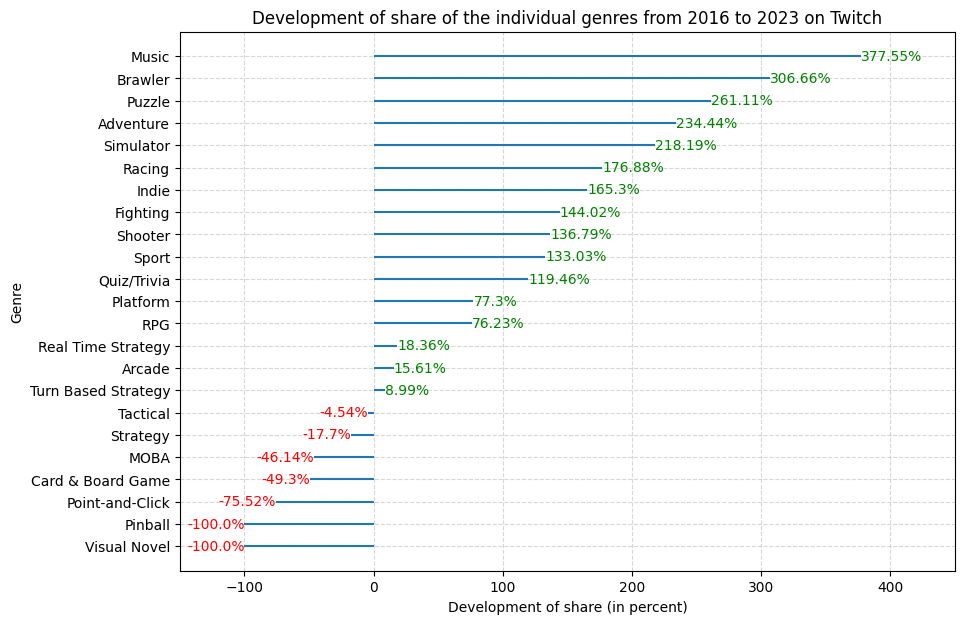

In [60]:
# Get years, genres, watched hours
df_plot10 = df_merged[['Year', 'Hours_watched', 'Genres']]
# Drop rows with NaN
df_plot10 = df_plot10.dropna()

# Get all possible years
years = df_plot10['Year'].unique()
# Create list with first and last year
years = [years[0], years[-1]]
# Filter rows that are not in these years
df_plot10 = df_plot10[df_plot10['Year'].isin(years)]

# Convert values to list for usage with explode
df_plot10['Genres'] = df_plot10['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot10 = df_plot10.explode('Genres')
# Rename Genres to Genre (for plot)
df_plot10 = df_plot10.rename({'Genres': 'Genre'}, axis='columns')

# Group genres, calculate average watched hours and sort appearances
df_plot10 = df_plot10.groupby(['Genre', 'Year']).mean()

# Convert hours watched to use the same conditions as the previous plot
df_plot10['Hours_watched'] = df_plot10['Hours_watched'] / 1000000
df_plot10['Hours_watched'] = df_plot10['Hours_watched'].round(2)

# Unstack MultiIndex to get DataFrame with genres and years as rows
df_plot10 = df_plot10['Hours_watched'].unstack()

# Fill NaN with zero
df_plot10 = df_plot10.fillna(0)

# Calculate percentage of total average watched hours for each genre in each year
df_plot10 = df_plot10.divide(df_plot10.sum(axis=0), axis=1)

# Calculate percentage change from first to last year
df_plot10 = df_plot10.pct_change(axis=1, fill_method=None) * 100

# Drop column 2016 because it has no values (starter column for year development)
df_plot10 = df_plot10.drop(2016, axis=1)
# Sort values descending by share development
df_plot10 = df_plot10.sort_values(years[1], ascending=False)

# Build plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title("Development of share of the individual genres from 2016 to 2023 on Twitch")
ax.grid(linestyle='--', alpha=0.5)
ax.set_xlabel("Development of share (in percent)")
ax.set_xlim(-150, 450)
ax.set_ylabel("Genre")

# Plot lines
ax.hlines(y=df_plot10.index[::-1], xmin=0, xmax=df_plot10.values[::-1])

# Annotate lines
for genre, value in zip(df_plot10.index, df_plot10.values):
    ax.text(value, genre, f"{round(value[0], 2)}%", 
            horizontalalignment='right' if value < 0 else 'left', 
            verticalalignment='center', 
            fontdict={'color':'red' if value < 0 else 'green', 'size':10})

# Show plot
plt.show()

### Discussion/Conclusions

#### Interpretation

The results fundamentally show that genres with the most video games do not necessarily have the highest popularity among players. While Adventure has the most video games, the MOBA genre has the highest average plays. There are no similarities across other genres, indicating that a high quantity of video games in a genre does not necessarily translate to high player engagement. This aligns with the typical scenario where not every video game can achieve high popularity, similar to other products where some are widely purchased while others are not. A comparison between the top 10 most played and most watched games reveals differences, even though Minecraft and Grand Theft Auto V are present in both rankings.

After individual examination, a generalization of hours watched by genres was also conducted, showing similarities between played and watched games. However, genres such as Platform or Sports do not align. The most popular genre in both played and watched categories is MOBA, while the popularity of other genres varies.

However, further analyses have shown that both watched and streamed hours have increased over the years, which means that a purely absolute view of the hours watched does not reflect the real development on Twitch. A yearly development of genres on Twitch shows that while MOBA has the highest absolute average watched hours, other genres like Indie, Simulator, and Sports experienced a much larger increase, especially in 2020. Relative shares of individual genres in the total watched hours confirm that MOBA lost 20% in share from 2016 to 2023, and other genres like Indie have significantly risen. To complete the analysis, the development of genre shares from 2016 to 2023 was examined, revealing that MOBA has significantly lost popularity, while other genres are now much more popular. However, the ranking of increased genres does not align with the most played genres, even though the Brawler genre is played a lot and is part of the genres whose popularity has increased.

After interpreting the results, it is necessary to address the question from the Introduction to determine whether popular games are also popular streaming formats. The analysis of games generally shows many Adventure games, but MOBA games are particularly played. Watched and streamed hours on Twitch have shown a positive trend over the years, reaching a peak in 2021, which could be related to the COVID-19 pandemic, as more activities were done at home during that period. However, in the joint consideration, it becomes evident that the most played games are not necessarily watched to the same extent. Through the generalization of video games into genres, it was found that MOBA is both played and watched a lot, but other genres do not have the same correlation, even though similarities exist. A more in-depth analysis of Twitch shows that while MOBA has the highest absolute popularity, it has lost proportionally over the years, as other genres have gained. However, a direct correlation to the popularity of played genres cannot be drawn from the Twitch development. In summary, based on the current results, it can be concluded that there is no direct correlation between the popularity of video games and their success as livestream formats. However, due to the problems mentioned in the Introduction, it is not possible to provide a definitive answer to the research question with the current data.

#### Limitations

Although both data sources are of high quality, there are nevertheless limitations that complicate or prevent the conclusion of hypotheses.

One limitation in Data Source 2 is that players (column: `Plays`) are recorded only once, making annual analyses impossible and generally complicating the understanding of the relationship between a game's popularity and hours watched. Typically, video games are particularly popular upon release, and this popularity decreases over time. The same applies to streams. However, since there is no extensive data on current players per month, such a comparison cannot be conducted. Another issue is that the plays come from Backloggd, an external site where users register and manually maintain their game lists. Apart from errors when, for example, someone forgets to enter their game, there is also the problem that not every player uses Backloggd, potentially making the values non-representative.

A general issue with the generalization of games is that many games belong to multiple genres, leading to them being counted multiple times, which could potentially distort the results.

#### Future Work

This project provides a good insight into the most popular genres of video games. However, as mentioned in the limitations, more extensive data would be helpful to more precisely answer whether there are correlations between popularly played and watched video games. Other methods, such as monthly WebScraping from Backloggd, could be employed to extract players who are still playing the game in a given month, providing a more nuanced understanding instead of relying solely on the general plays of a video game.

Alternatively, the generalization of video games could also be conducted through other factors, such as the platforms on which the video games were released or the publisher that released the video game. More complex analyses could explore how video games develops after their release.

In essence, research in this area is interesting because the results can be utilized to estimate whether a video game set for future release might attain a certain level of popularity on Twitch. With more comprehensive data available, it could also reveal connections between players and viewers.